# Homework #1: AB-testing<br>and the Multi-Armed Bayesian Bandit

Student: Ante Malenica

### You have three choices... choose wisely, my friends...


|Option|The "Red" one|The "Blue" one|The "Other" one|
|-|-|-|-|
|Unknown Probability of Success|$\theta_A$ | $\theta_B$ | $\theta_C$ |

$$p(\theta_j|x_j,n_j) \propto \theta^{x_j+\alpha_j-1}(1-\theta_j)^{n-x+\beta_j-1}  \Rightarrow \; \text{What distribution?}$$

- Try one out, and collect that data update...
    - What's the data?
    - What's the update for the posterior in question?
- Which one of the three choices will you try out? How will you choose?
- Hints: You can use *simulation* to find out the *relative belief* (i.e., probability) that each of the choices is the best. Posterior distributions characterize your beliefs about the parameters $\theta_A$, $\theta_B$, and $\theta_C$. What can you learn by repeatedly sampling values from the posterior distribution while comparing the values of each triplet? If you know the chances that A, B, and C are the best choice, how could you balance *exploration versus exploitation* when choosing which of the possible options to collect the next data point on next?

## What's the data?

Given the three choices, the "Red" one, the "Blue" one, and the "Other" one, with unknown probabilities of success, $\theta_A, \theta_B, \theta_C \in [0,1]$ respectively, the data will be simulated for some "large enough" selections, say, $n = 100$. Additionally, the outcomes' successes, and total trials for the possible choices will be logged to update each beta distributions' parameters, $\alpha$ and $\beta$. Before any selection occurs, every distribution's $\alpha = \beta = 1$. Here we will also fix the true parameters for $\theta_A = 0.1$, $\theta_B = 0.2$, and $\theta_C = 0.3$.


In [ ]:
import numpy as np
from scipy.stats import beta

np.random.seed(1)

# 0th list index is data corresponding to data model with theta_A
# 1st list index is data corresponding to data model with theta_B
# 2nd list index is data corresponding to data model with theta_C
thetas = [0.1, 0.2, 0.3]
alphas = np.ones(len(thetas))
betas = np.ones(len(thetas))
successes = np.zeros(len(thetas))
total_trials = np.zeros(len(thetas))
n = 100

## What's the update for the posterior in question?

The posterior updates according to the outcome for the selected option. For some option, the corresponding beta distribution, denoted $B(\alpha,\beta)$, updates to $B(\alpha',\beta')$, where:

$$B(\alpha',\beta') =  
\begin{cases}
B(\alpha + 1, \beta) & \text{if success} \\
B(\alpha, \beta + 1) & \text{if failure}
\end{cases}
$$

This event outcome compliment the success and failure dynamic defined for each bernoulli trial, where, as more selections occur, these bernoulli trials can model a binomial distribution, hence the distribution on the final line in ["A first (toy) model: beta-binomial"](https://github.com/pointOfive/STA365_W24_Bayes/blob/main/Bayes1_Intro2Bayes.ipynb) (also the distribution explicitly defined in this homework).

## Which one of the three choices will you try out? How will you choose?

Over $n$-many iterations, the optimial choice will depend on the highest probability of success produced by each beta distribution for each iteration.

The following code snippet outlines this selection and redefinition for each beta distribution. It as well logs data needed for visualizing the selection's progression.

In [ ]:
selection_counts = [[0] for _ in range(len(alphas))] # Counter for progression

for trial in range(n):
    # Selection Algorithm ---------------------------------------------------- #
    probs = [beta(alphas[i], betas[i]).rvs() for i in range(len(thetas))]
    index_to_best_probability = np.argmax(probs)

    # <param_update> increments 1 if true or 0 if false
    param_update = np.random.rand() < thetas[index_to_best_probability]
    successes[index_to_best_probability] += param_update
    total_trials[index_to_best_probability] += 1

    # Update the posterior distribution (alpha, beta parameters)
    alphas[index_to_best_probability] += param_update
    betas[index_to_best_probability] += 1 - param_update
    # ------------------------------------------------------------------------ #

    # For data processing in a later cell (affirmation of selection process)
    # Graph implementation: ChatGPT-4 assisted
    for i in range(len(alphas)):
        if i == index_to_best_probability:
            selection_counts[i].append(selection_counts[i][-1] + 1)
        else:
            selection_counts[i].append(selection_counts[i][-1])


Here, we can also visualize the progression of option selection over each iteration.

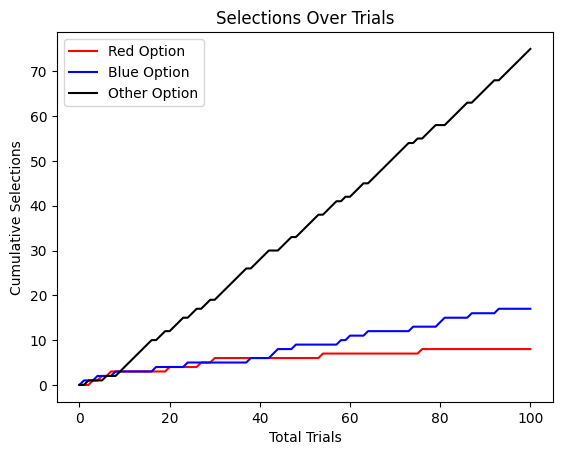

In [ ]:
import matplotlib.pyplot as plt
# Plotting
labels = ["Red Option", "Blue Option", "Other Option"]
label_colours = ["red", "blue", "black"]
for i in range(len(alphas)):
    plt.plot(range(n + 1), selection_counts[i], label=labels[i],
             color=label_colours[i])

plt.xlabel('Total Trials')
plt.ylabel('Cumulative Selections')
plt.title('Selections Over Trials')
plt.legend()
plt.show()

And moreover the posterior distributions after $n$-many iterations. Given the fixed parameters defined in **'What's the data?'**, we can see that the "Other" option is the most suitable selection compared to "Red" and "Blue".

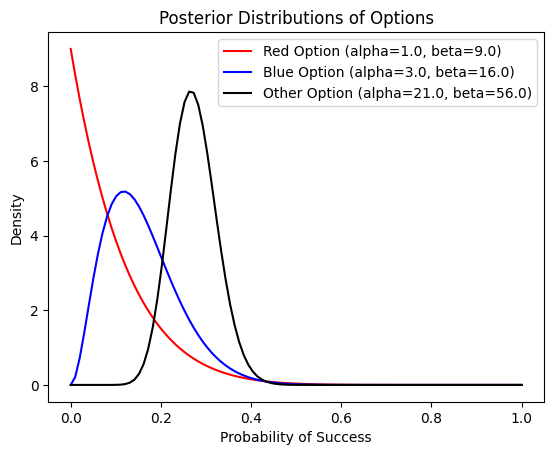

In [ ]:
# Plotting beta distributions (ChatGPT-4 assisted)
x = np.linspace(0, 1, n)

for i in range(len(alphas)):
    # Calculate the PDF for the beta distribution
    y = beta.pdf(x, alphas[i], betas[i])
    plt.plot(x, y, label=f'{labels[i]} (alpha={alphas[i]}, beta={betas[i]})',
             color=label_colours[i])

plt.xlabel('Probability of Success')
plt.ylabel('Density')
plt.title('Posterior Distributions of Options')
plt.legend()
plt.show()
